In [ ]:
from collections import defaultdict
from matplotlib_venn import venn3
import dataloader
import itertools
from net import CharRNN
import torch
from config import *
import numpy as np
import pandas as pd
from IPython.display import display
%matplotlib inline

(trl, tel, val), vocab = dataloader.load(FILE_PATH, DEVICE, SPLITS, BATCH_SIZE, SEQ_LEN, unique=True)

In [ ]:
sets = {}
for params in [("rnn", 1, 32), ("gru", 1, 32), ("gru", 1, 128)]:
    net = CharRNN.load_from_file(*params).eval()

    val = set()
    offset = 0
    for x, y in tel:
        correct = net.forward(x).argmax(-1) == y.flatten()
        val |= {n + offset for n, b in enumerate(correct) if b}
        offset += len(y.flatten())
    sets[net.name()] = val
venn3(sets.values(), sets.keys());

'train'

NameError: name 'hidden_size' is not defined

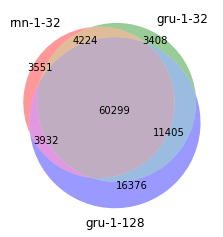

In [3]:
model_names = ["lstm", "rnn", "gru"]
n_layers = [1, 2, 3, 4]
hidden_sizes = [32, 64, 128, 256, 512, 1024]
corrects, losses = [], []

for loader, loadername in (trl, "train"), (tel, "tel"):
    display(loadername)
    for MODEL_NAME in model_names:
        for N_LAYERS in n_layers:
            for HIDDEN_SIZE in hidden_sizes:
                net = CharRNN.load_from_file(MODEL_NAME, N_LAYERS, HIDDEN_SIZE).eval()
                correct, loss = [], []
                for x, y in loader:
                    out = net.forward(x)
                    correct += (out.argmax(-1) == y.flatten()).tolist()
                    loss += [(torch.nn.functional.cross_entropy(out, y.flatten())).tolist()]
                corrects.append(np.mean(correct))
                losses.append(np.mean(loss))

    for title, arr in (("accuracy", corrects), ("loss", losses)):
        arr = np.array(arr).reshape((len(hidden_size), len(model_names) * len(n_layers)))
        columns = pd.MultiIndex.from_product([model_names, n_layers])
        df = pd.DataFrame(arr, columns=columns, index=hidden_size)
        df.columns.name = title
        display(df.round(3))
